In [36]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sn
plot_params = {'color': '0.75',
                'style': '.-',
                'markeredgecolor': '0.25',
                'markerfacecolor': '0.25',
                'legend': False}
sn.set_style("dark")
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tscv import GapRollForward
from scipy import stats
import statsmodels.api as sm
from scipy.special import inv_boxcox

In [30]:
def rmse(y, y_pred):
    return np.sqrt(((y - y_pred) ** 2).mean())
def mse(y, y_pred):
    return ((y - y_pred) ** 2).mean()
def mae(y, y_pred):
    return ((y - y_pred).abs()).mean()
def mape(y, y_pred):
    return ((y - y_pred).abs() / y).mean() * 100
def evaluate(y, y_pred):
    print("MAE:", mae(y, y_pred))
    #print("MSE:", mse(y, y_pred))
    print("RMSE:", rmse(y, y_pred))
    print("MAPE:", mape(y, y_pred))

# ARIMA

• ARIMA models is only applied to stationary data. ARIMA(p, d, q). Let’s decompose its parts to understand it separately first.

• AR: refers to Auto-regressive models. It is referred to AR(p) model to indicate its order.

• In a multiple regression model, we forecast the variable of interest using a linear combination of predictors.

• In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable. Uses maximum likelihood estimators to determine coefficients instead of least squares. Useful for short term forecasts.

• The term autoregression indicates that it is a regression of the variable against itself. 𝑦𝑡 = 𝑐 + 𝜙1𝑦𝑡−1 + 𝜙2𝑦𝑡−2 + ⋯ + 𝜙𝑝𝑦𝑡−𝑝 + 𝜀𝑡

• I: refer to integrated, which means how many differences is applied to make time series data stationary. Shown in parameter d in ARIMA(p, d, q).

• MA: refers to Moving Average models. 𝑦𝑡 = 𝑐 + 𝜃1𝜖𝑡−1 + 𝜃2𝜖𝑡−2 + ⋯ + 𝜃𝑞𝜖𝑡−𝑞 + 𝜀𝑡 It is referred to MA(q) model to indicate its order.

• MA models are conceptually a linear regression of the current value of the series against the white noise of one or more of the previous values of the series. Moving average models should not be confused with the moving average smoothing discussed earlier. A moving average model is used for forecasting future values, while moving average smoothing is used for estimating the trend-cycle of past values.

• In MA models, the noise at each point is assumed to come from a normal distribution with mean 0 and constant variance (White Noise).

In [42]:
def rolling_forward(X,y, window_size, algorithm_func):
    # Split the dataset into training and testing sets
    train_size = int(len(df) * 0.8)
    y_train, y_test = y[:train_size], y[train_size:]

    tscv = GapRollForward(min_train_size=24, gap_size=0, max_test_size=window_size)

    predictions = []
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
      # Select train and test data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      # Plot train and test data in separate subplots
        yhat = algorithm_func(X_train,y_train, y_test, isevaluated=False)

        predictions+=yhat.tolist()

    # Calculate the performance metrics
    print(yhat)
    print(len(predictions), len(y))
    evaluate(y[24:], predictions)
  

In [43]:
def arima(x_train,y_train, y_test, isevaluated=True):
    data = pd.DataFrame()
    transformed_data, lambda_param = stats.boxcox(y_train)
    data['Passengers'] = transformed_data
    data['Month'] = x_train
    data.set_index('Month', inplace=True)

    # Fit two ARIMA models with different orders
    model1 = sm.tsa.ARIMA(data, order=(3, 1, 1))
    #model2 = sm.tsa.ARIMA(data, order=(3, 1, 0))
    result1 = model1.fit()
    #result2 = model2.fit()

    # Print the AIC and BIC values of the two models
    #print("Model 1 AIC: {:.2f}, BIC: {:.2f}".format(result1.aic, result1.bic))
    #print("Model 2 AIC: {:.2f}, BIC: {:.2f}".format(result2.aic, result2.bic))

    yred = result1.forecast(steps  = len(y_test))
    yred = inv_boxcox(yred, lambda_param)
    # yred = pd.Series(yred.values)
    # y_test.reset_index(inplace=True)
    if isevaluated:
          evaluate(pd.Series(y_test.values), pd.Series(yred.values))
    return yred.values

## WE used ACF & ACF
To determine the optimal number of lags to include in a time series model, you can use the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots.

In Python, you can generate ACF and PACF plots using the plot_acf and plot_pacf functions from the statsmodels.graphics.tsaplots module, respectively.

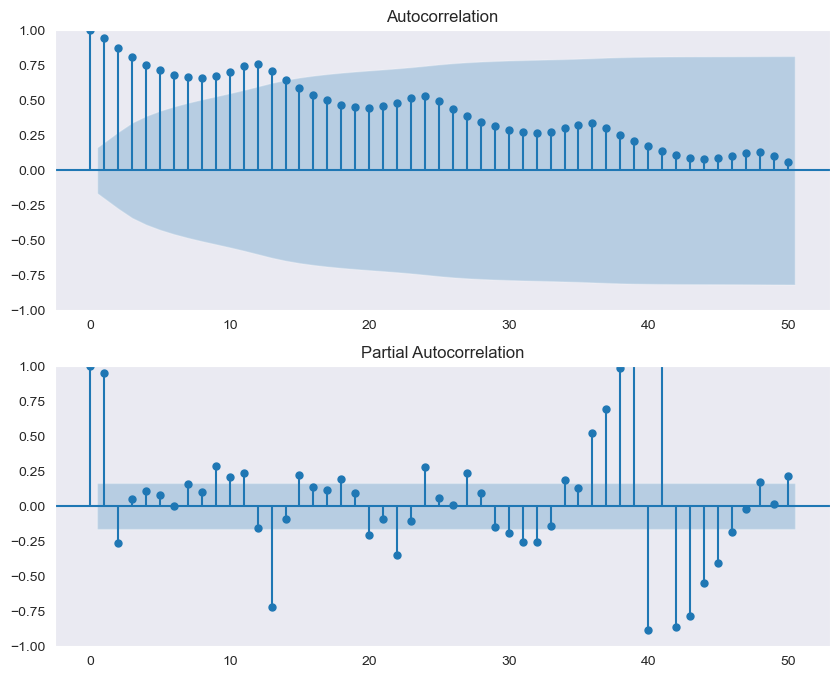

In [44]:
df = pd.read_csv('AirPassengers.csv', index_col='Month', parse_dates=True)

# Plot ACF and PACF
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
plot_acf(df['#Passengers'], ax=ax[0], lags=50)
plot_pacf(df['#Passengers'], ax=ax[1], lags=50)
plt.show()

## How selsct Amira Parameters?

From PACF & ACF We choose

1- model1 = sm.tsa.ARIMA(data, order=(3, 1, 1))

2- model2 = sm.tsa.ARIMA(data, order=(3, 1, 0))

We don't go with order=(3, 1, 13) becaue it overfit based on test AIC & BIC

The general rule of thumb is that a lower AIC or BIC value indicates a better fitting model. Therefore, you would choose the model with the lowest AIC or BIC value. However, it is also important to consider the practical implications of each model, such as whether the parameters are interpretable or whether the residuals have any significant patterns. It is also a good idea to compare the performance of multiple models using different criteria, and not solely rely on AIC or BIC.

Based on the AIC and BIC values, Model 1 seems to be better than Model 2 as it has a lower AIC and BIC. Lower values of AIC and BIC indicate a better fit for the model. Therefore, Model 1 is the preferred model between the two.

In [45]:
df = pd.read_csv('AirPassengers.csv', parse_dates=True)
X = df['Month']
y = df['#Passengers']

In [46]:
rolling_forward(X,y, 1, arima)

[385.8379249]
120 144
MAE: 26.06929718618204
RMSE: 32.98540132474256
MAPE: 8.358929642914932
